In [ ]:
#load packages
import os
import geopandas as gpd
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from shapely.geometry import Point
from shapely.ops import nearest_points
from folium.plugins import MiniMap
import pandas as pd
from pyproj import CRS
import matplotlib.pyplot as plt


In [674]:
#plt.ion() # make the plotting interactive

# generate matplotlib handles to create a legend of the features we put in our map.
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  # get the length of the color list
    handles = []
    for i in range(len(labels)):
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i % lc], edgecolor=edge, alpha=alpha))
    return handles

In [675]:
# create a scale bar
def scale_bar(ax, location=(0.92, 0.95)):
    x0, x1, y0, y1 = ax.get_extent()
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    ax.plot([sbx, sbx - 20000], [sby, sby], color='k', linewidth=9, transform=ax.projection)
    ax.plot([sbx, sbx - 10000], [sby, sby], color='k', linewidth=6, transform=ax.projection)
    ax.plot([sbx-10000, sbx - 20000], [sby, sby], color='w', linewidth=6, transform=ax.projection)

    ax.text(sbx, sby-4500, '20 km', transform=ax.projection, fontsize=8)
    ax.text(sbx-12500, sby-4500, '10 km', transform=ax.projection, fontsize=8)
    ax.text(sbx-24500, sby-4500, '0 km', transform=ax.projection, fontsize=8)

In [676]:
# Load the shapefiles
patients =  gpd.read_file(os.path.abspath('datasets/patient.shp'))
facilities = gpd.read_file(os.path.abspath('datasets/health_facilities.shp'))
roads = gpd.read_file(os.path.abspath('datasets/road.shp'))
viral_suppressions = gpd.read_file(os.path.abspath('datasets/patient.shp'))
outline = gpd.read_file(os.path.abspath('datasets/district.shp'))


In [677]:
# Define projection
# Reproject the GeoDataFrames to UTM Zone 35S
outline = outline.to_crs("EPSG:32735")
patients = patients.to_crs("EPSG:32735")
facilities = facilities.to_crs("EPSG:32735")
viral_suppressions = viral_suppressions.to_crs("EPSG:32735")
roads = roads.to_crs("EPSG:32735")

# Define the map projection
crs = ccrs.UTM(35, southern_hemisphere=True)


In [679]:
# Create a 5km buffer around each health facility
facilities_buffered = facilities.copy()
facilities_buffered['geometry'] = facilities_buffered.buffer(5000)

In [680]:
# Count the number of patients within the 5km radius of each health facility
for index, facility in facilities_buffered.iterrows():
    patients_within_buffer = patients[patients.within(facility.geometry)]
    facility_name = facility['Name'] # Get the name of the facility
    print("{}' has {} patients within 5km radius.".format(facility_name, len(patients_within_buffer)))

Chalabesa Rural Health Centre' has 2 patients within 5km radius.
Chaya Health Post' has 2 patients within 5km radius.
Chibansa Urban Health Centre' has 4 patients within 5km radius.


In [681]:
#Count the number of patients outside the 5km radius of each health facility
for index, facility in facilities_buffered.iterrows():
    patients_outside_buffer = patients[~patients.within(facility.geometry)]
    facility_name = facility['Name'] # Get the name of the facility
    print("{}' has {} patients outside 5km radius.".format(facility_name, len(patients_outside_buffer)))

Chalabesa Rural Health Centre' has 30 patients outside 5km radius.
Chaya Health Post' has 30 patients outside 5km radius.
Chibansa Urban Health Centre' has 28 patients outside 5km radius.


In [682]:
#Calculate the distances patients outside 5km travel to access HIV services at the nearest health facility
patients_outside_buffered = patients[~patients.within(facilities_buffered.geometry.unary_union)]
patients_outside_buffered_nearest = gpd.GeoDataFrame(geometry=list(patients_outside_buffered.geometry))
patients_outside_buffered_nearest['nearest_facility'] = [nearest_points(patient, facilities.geometry.unary_union)[1] for patient in patients_outside_buffered.geometry]
patients_outside_buffered_nearest['distance_to_facility'] = patients_outside_buffered_nearest.apply(lambda row: row['geometry'].distance(row['nearest_facility']), axis=1)
print("Patients outside 5km radius travel an average distance of {} meters to access HIV services at the nearest health facility.".format(patients_outside_buffered_nearest.distance_to_facility.mean()))

Patients outside 5km radius travel an average distance of 11755.662291205159 meters to access HIV services at the nearest health facility.


In [683]:
#Count the number of patients with suppressed and unsuppressed viral suppression status within and outside the radius of each health facility
# perform a spatial join between health facilities and patients
patients_within_radius = gpd.sjoin(patients, facilities, how='inner', predicate='within')


In [684]:
#Count the number of patients with suppressed and unsuppressed viral suppression status within and outside the radius of each health facility
for index, facility in facilities_buffered.iterrows():
    patients_within_buffer = patients[patients.within(facility.geometry)]
    patients_within_buffer_viral = patients_within_buffer.merge(viral_suppressions, on='FID_')
    patients_within_buffer_viral_suppressed = patients_within_buffer_viral[patients_within_buffer_viral['viral_supp_x'] == 'suppressed']
    patients_within_buffer_viral_unsuppressed = patients_within_buffer_viral[patients_within_buffer_viral['viral_supp_x'] == 'unsuppressed']
    facility_name = facility['Name'] # Get the name of the facility
    print("{}' has {} patients within 5km radius with suppressed viral load.".format(facility_name, len(patients_within_buffer_viral_suppressed)))
    print("{}' has {} patients within 5km radius with unsuppressed viral load.".format(facility_name, len(patients_within_buffer_viral_unsuppressed)))
    
    patients_outside_buffer = patients[~patients.within(facility.geometry)]
    patients_outside_buffer_viral = patients_outside_buffer.merge(viral_suppressions, on='FID_')
    patients_outside_buffer_viral_suppressed = patients_outside_buffer_viral[patients_outside_buffer_viral['viral_supp_y'] == 'suppressed']
    patients_outside_buffer_viral_unsuppressed = patients_outside_buffer_viral[patients_outside_buffer_viral['viral_supp_y'] == 'unsuppressed']
    facility_name = facility['Name'] # Get the name of the facility
    print("{}' has {} patients outside 5km radius with suppressed viral load.".format(facility_name, len(patients_outside_buffer_viral_suppressed)))
    print("{}' has {} patients outside 5km radius with unsuppressed viral load.".format(facility_name, len(patients_outside_buffer_viral_unsuppressed)))
    print()

Chalabesa Rural Health Centre' has 2 patients within 5km radius with suppressed viral load.
Chalabesa Rural Health Centre' has 0 patients within 5km radius with unsuppressed viral load.
Chalabesa Rural Health Centre' has 21 patients outside 5km radius with suppressed viral load.
Chalabesa Rural Health Centre' has 9 patients outside 5km radius with unsuppressed viral load.

Chaya Health Post' has 2 patients within 5km radius with suppressed viral load.
Chaya Health Post' has 0 patients within 5km radius with unsuppressed viral load.
Chaya Health Post' has 21 patients outside 5km radius with suppressed viral load.
Chaya Health Post' has 9 patients outside 5km radius with unsuppressed viral load.

Chibansa Urban Health Centre' has 2 patients within 5km radius with suppressed viral load.
Chibansa Urban Health Centre' has 2 patients within 5km radius with unsuppressed viral load.
Chibansa Urban Health Centre' has 21 patients outside 5km radius with suppressed viral load.
Chibansa Urban Heal

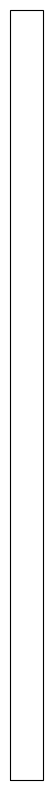

In [685]:
# Create a Figure object and a GeoAxesSubplot object
myFig = plt.figure(figsize=(10, 10))
ax = myFig.add_subplot(1, 1, 1, projection=crs)

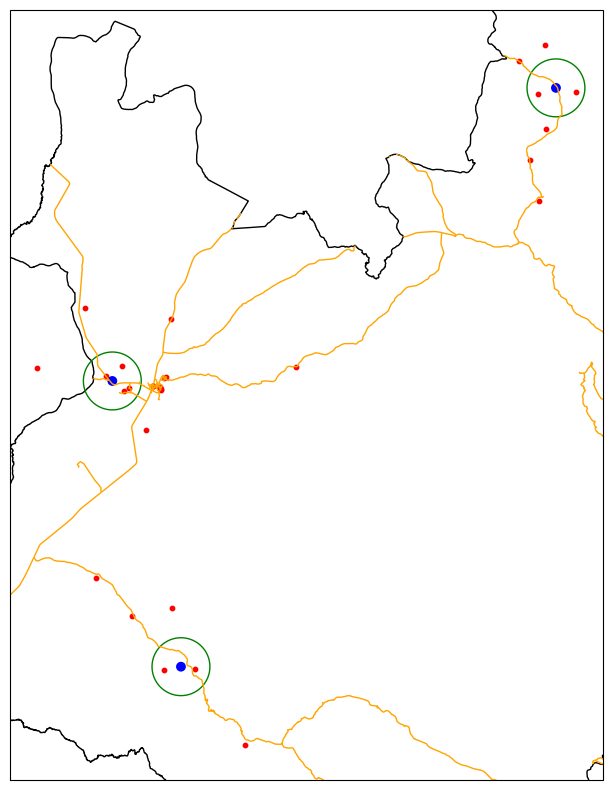

In [686]:
# Define the marker size
marker_size_patient = 10
marker_size_facility = 50

# Add the point data as a scatter plot
ax.scatter(patients.geometry.x, patients.geometry.y, transform=crs, s=marker_size_patient, c='red',edgecolor='red', alpha=1)
ax.scatter(facilities.geometry.x, facilities.geometry.y, transform=crs, s=marker_size_facility, c='blue',edgecolor='none', alpha=1)

# Add the shapefiles to the map
ax.add_geometries(outline['geometry'], crs=crs, facecolor='none', edgecolor='black', linewidth=1, label='Districts')
#ax.add_geometries(patients['geometry'], crs=crs, facecolor='red', edgecolor='black', alpha=1)
#ax.add_geometries(facilities['geometry'], crs=crs, facecolor='blue', edgecolor='none', alpha=1)
ax.add_geometries(facilities_buffered['geometry'], crs=crs, facecolor='none', edgecolor='green', alpha=1)
ax.add_geometries(roads['geometry'], crs=crs, facecolor='none', edgecolor='orange', linewidth=1, label='Roads')


myFig

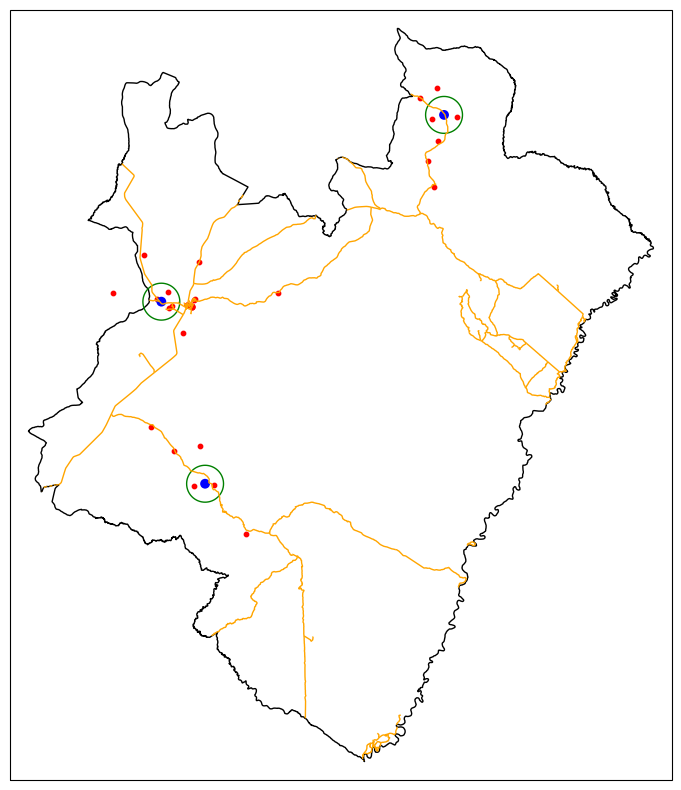

In [687]:
# Set the map extent to the extent of the GeoDataFrame
xmin, ymin, xmax, ymax = outline.total_bounds
ax.set_extent([xmin-5000, xmax+5000, ymin-5000, ymax+5000], crs=crs)

myFig

In [688]:
# note: if you change the color you use to display lakes, you'll want to change it here, too
facilities_handle = ax.plot(facilities.geometry.x, facilities.geometry.y, 's', color='blue', ms=10, transform=crs)
patients_handle = ax.plot(patients.geometry.x, patients.geometry.y, 's', color='red', ms=6, transform=crs)
roads_handle = [mlines.Line2D([], [], color='orange')]
buffer_handle = generate_handles(['5km radius'], ['green'])

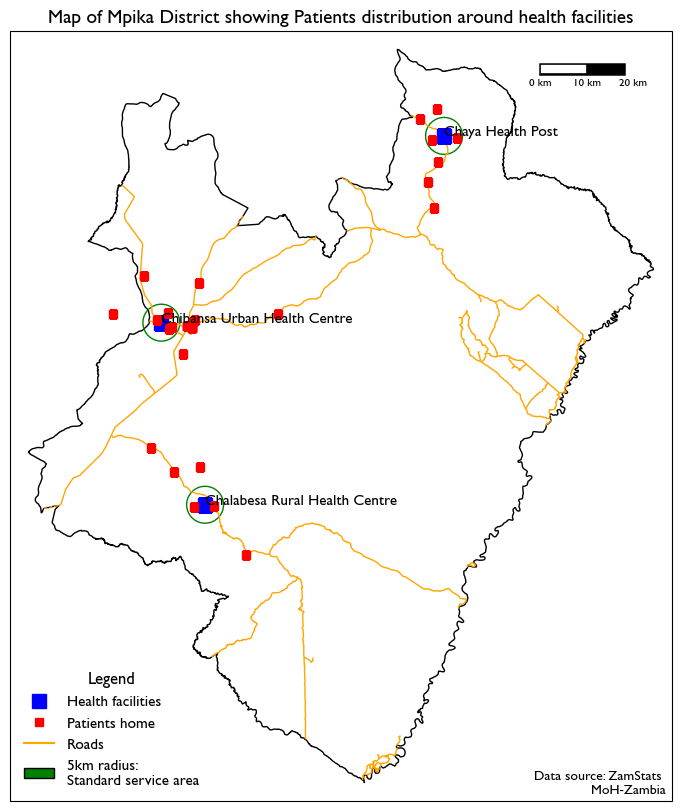

In [694]:
# you want to add to the legend
# Set the font family for the title
plt.rcParams['font.family'] = 'Gill Sans MT'


handles = facilities_handle + patients_handle + roads_handle + buffer_handle
labels = ['Health facilities', 'Patients home', 'Roads', '5km radius:\nStandard service area']

# Combine all handles and labels into one list
all_handles = handles
all_labels = labels

leg = ax.legend(all_handles, all_labels, title='Legend', title_fontsize=12, 
                 fontsize=11, loc='lower left', frameon=False, framealpha=1)

# Set the map title
ax.set_title('Map of Mpika District showing Patients distribution around health facilities', fontsize=14)

myFig

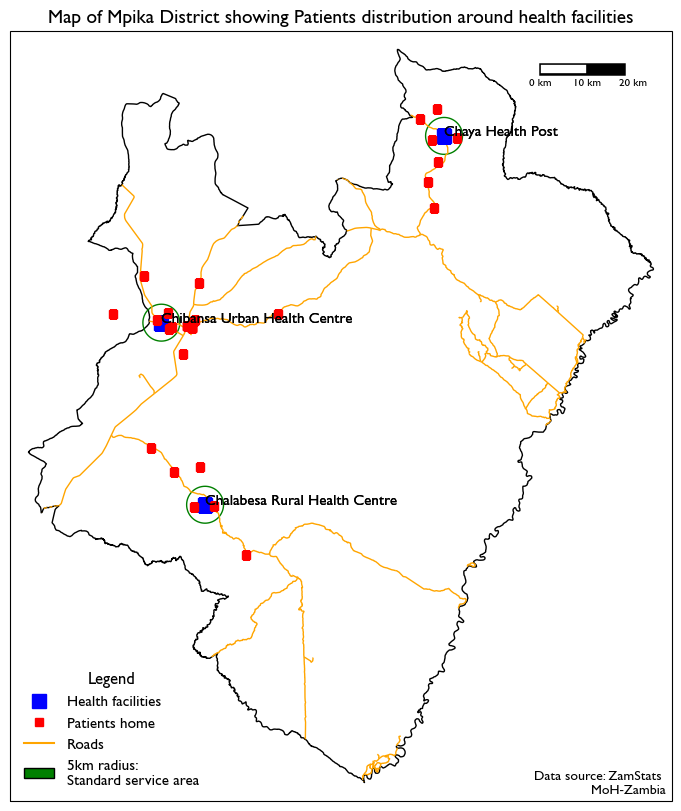

In [695]:
for ind, row in facilities.iterrows(): # towns.iterrows() returns the index and row
   x, y = row.geometry.x, row.geometry.y # get the x,y location for each town
   ax.text(x, y, row['Name'].title(), fontsize=11, transform=crs) # use plt.text to place a label at x,y
myFig

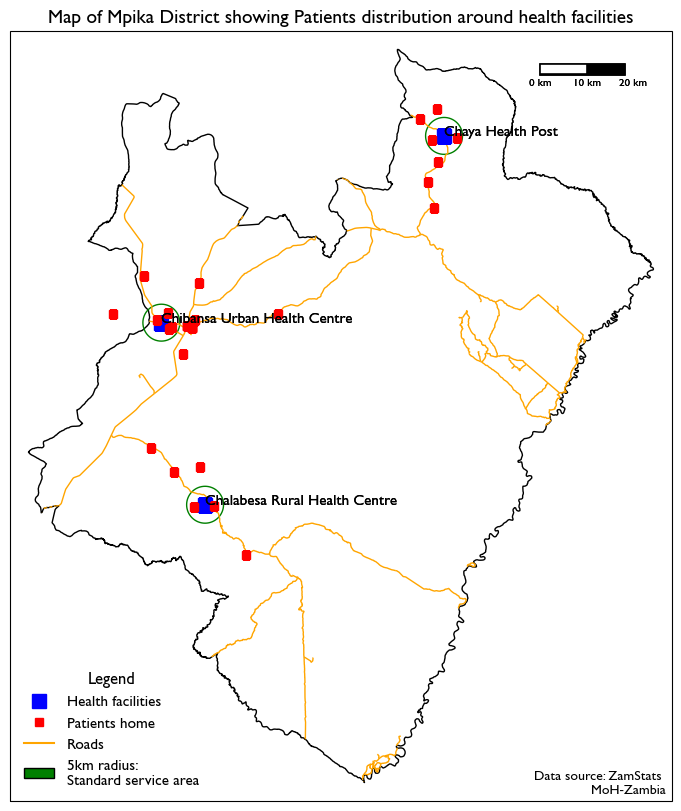

In [696]:
scale_bar(ax)
myFig

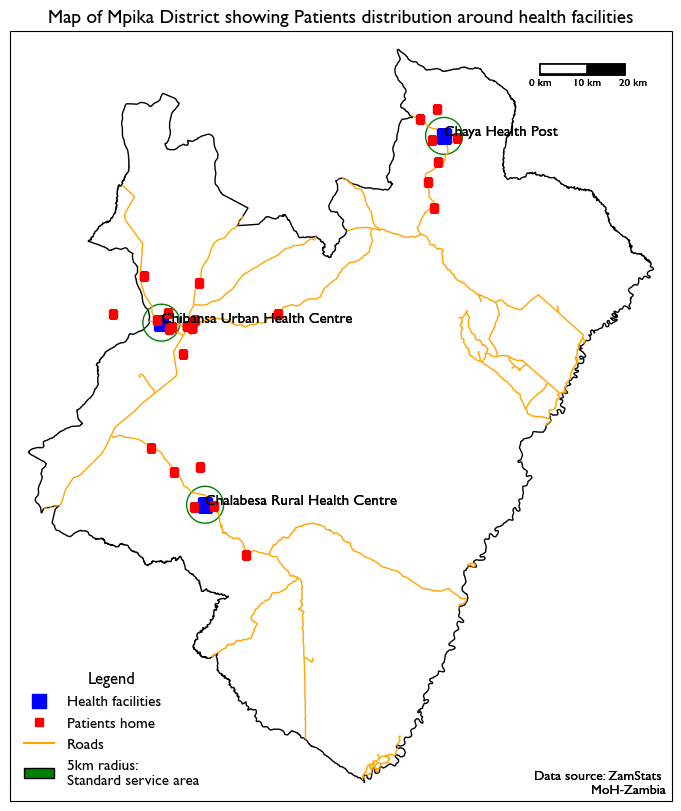

In [697]:
# add a data source to the map
ax.text(0.99, 0.01, 'Data source: ZamStats \nMoH-Zambia', ha='right', transform=ax.transAxes)
myFig

In [698]:
myFig.savefig('egm722_project.png', bbox_inches='tight', dpi=300)